In [1]:
import torch
from torch.utils.data import DataLoader

import cv2
import numpy as np
import matplotlib.pyplot as plt

import config
from model import FoodClassifier, ModelHandler
from dataset import Food11Dataset
from PIL import Image

In [2]:
INFER_MODEL = f"{config.MODEL_FOLDER}/resnet18_1_91.54.pt"

In [3]:
# Dataset
dataset = Food11Dataset(config.TEST_DIR, config.ATF, preproc=True, augment=False)
dataloader = DataLoader(dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=0)

In [4]:
# Model handler
mh = ModelHandler(
        model=FoodClassifier(
            model_name = config.MODEL_NAME,
            pretrained = config.PRETRAINED,
            out_classes = config.NUM_CLASSES
        ),
        test_dataloader=dataloader,
        device=config.ACCELERATOR
)

# Load model
mh.load(INFER_MODEL)

# Quick test
mh.model(torch.randn(1, 3, 224, 224).to(config.ACCELERATOR))

tensor[1, 11] x∈[-4.041, -0.089] μ=-2.042 σ=1.420 grad AddmmBackward0 cuda:0

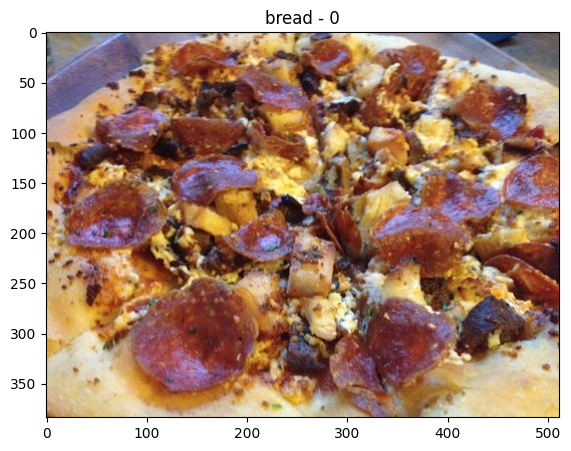

In [5]:
img = Image.open(dataset.imgs[200])
mh.predict(img, show_results=True, label_dict=dataset.idx_to_class)

Class Activation Map (CAM) is technique that could be implemented here for food localization [http://cnnlocalization.csail.mit.edu].


Objective
Use the dataset to train a model. The model may be made from scratch or pretrained model from here: [https://s3-us-west-2.amazonaws.com/models-a-c-ozbek/model_food.h5] Put the model file in the same level folder of the script. The dataset choice is left upto your discretion. The idea is to showcase the activation map around the region of food present in the image. In simple terms, showcase the predictive performance of the model for food category or objective of your choice.

https://github.com/jacobgil/pytorch-grad-cam

In [6]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [7]:
data_idx = 10

methods = [
    dict(method=GradCAM, method_str='GradCAM'),
    dict(method=HiResCAM, method_str='HiResCAM'),
    dict(method=ScoreCAM, method_str='ScoreCAM'),
    dict(method=GradCAMPlusPlus, method_str='GradCAM++'),
    dict(method=AblationCAM, method_str='AblationCAM'),
    dict(method=XGradCAM, method_str='XGradCAM'),
    dict(method=EigenCAM, method_str='EigenCAM'),
    dict(method=FullGrad, method_str='FullGrad'),
]

data_label = int(dataset[data_idx][1])
data_label_text = dataset.idx_to_class[data_label]

input_tensor = dataset[data_idx][0].unsqueeze(0).type(torch.FloatTensor).to(config.ACCELERATOR)
target_category = [ClassifierOutputTarget(data_label)]
img_np = cv2.cvtColor(cv2.imread(dataset.imgs[data_idx]), cv2.COLOR_RGB2BGR) / 255.0
img_np = cv2.resize(img_np, config.INPUT_SIZE)

In [8]:
# for resnet18
target_layers = [mh.model.model.layer4[-1]]

100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 76.34it/s]


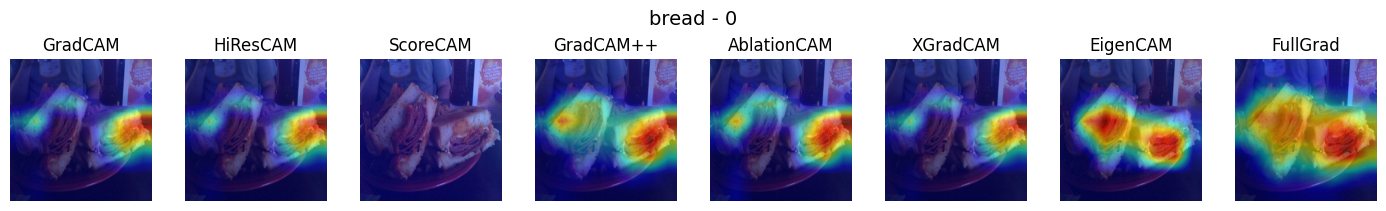

In [9]:
cam_imgs = []
for method in methods:
    cam = method['method'](model=mh.model, target_layers=target_layers, use_cuda=(True if config.ACCELERATOR == "cuda" else False))
    grayscale_cam = cam(input_tensor=input_tensor, targets=target_category)

    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)    
    cam_imgs.append((visualization, f"{str(method['method_str'])}"))

fig, axs = plt.subplots(1, 8, figsize=(14, 2), constrained_layout=True)
fig.suptitle(f'{data_label_text} - {data_label}', fontsize=14)

for i, (img, title) in enumerate(cam_imgs):
    axs[i].imshow(img)
    axs[i].set_title(title)
    axs[i].axis('off')
plt.show()